# Salt Lake City Historical Real Estate Data

## Exploring the Zillow Research Data Sets and Extracting SLC Relevant Data

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
import os.path
import pandas as pd
import urllib.parse
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing

In [53]:
# import csv for downloaded from Zillow Research 'Home Values'

zr_data_set_loc = '~/Desktop/K2_DataScience/K2_Project2/zillow_research_home_values'
one_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_1bedroom.csv'))
two_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_2bedroom.csv'))
three_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_3bedroom.csv'))
four_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_4bedroom.csv'))
five_or_more_br_df = pd.read_csv(os.path.join(zr_data_set_loc, 'Zip_Zhvi_5BedroomOrMore.csv'))

In [54]:
# adding a column for bedroom number; 5 or more will be categorized as 5
one_br_df['beds'] = 1
two_br_df['beds'] = 2
three_br_df['beds'] = 3
four_br_df['beds'] = 4
five_or_more_br_df['beds'] = 5

In [55]:
# concatenate all bedrooms listing into one data frame
listings_historical = pd.concat([one_br_df, two_br_df, three_br_df, four_br_df, five_or_more_br_df])

# pull out only Utah listings
listings_historical_UT = listings_historical[listings_historical['State'] == 'UT']

# pull out only listings relevant to our zip codes of interest

slc_zip_list = [84101, 84102, 84103, 84104, 84105, 84106, 84107, 84108, 84109, 84111, 84114, 
                84115, 84054, 84119, 84116, 84117, 84118, 84120, 84121, 84123, 84124, 84128, 
                84129, 84010, 84087]

listings_historical_slc = listings_historical_UT[listings_historical_UT['RegionName'].isin(slc_zip_list)]

In [56]:
# import zip_to_neighborhood
zip_to_neighborhood = pd.read_csv('/Users/jeff/Desktop/K2_DataScience/K2_Project2/zillow_analysis_notebooks/zip_codes_to_neighborhood.csv', 
                           sep=',')

# zip code name name to RegionName to make joining easy

zip_to_neighborhood.columns = ['RegionName', 'neighborhood']

# join neighborhood classifications to the existing data frame

listings_historical_slc = pd.merge(listings_historical_slc, zip_to_neighborhood, on='RegionName', how='outer')

In [57]:
listings_historical_slc.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,beds,neighborhood
0,94477.0,84117,Holladay,UT,Salt Lake City,Salt Lake,1385.0,NaN,NaN,NaN,...,113400.0,114600.0,114700.0,114500.0,116800.0,122600.0,128300.0,130500.0,1.0,Millcreek_Holladay
1,94477.0,84117,Holladay,UT,Salt Lake City,Salt Lake,3893.0,156600.0,157300.0,157500.0,...,312600.0,313100.0,314300.0,315600.0,316300.0,317700.0,321100.0,324500.0,3.0,Millcreek_Holladay
2,94477.0,84117,Holladay,UT,Salt Lake City,Salt Lake,3813.0,183400.0,185600.0,187800.0,...,403000.0,405600.0,407500.0,406500.0,408800.0,416000.0,423300.0,425600.0,4.0,Millcreek_Holladay
3,94477.0,84117,Holladay,UT,Salt Lake City,Salt Lake,2889.0,228100.0,228500.0,228400.0,...,485900.0,488800.0,491100.0,492800.0,498500.0,507600.0,515100.0,518100.0,5.0,Millcreek_Holladay
4,94466.0,84106,Salt Lake City,UT,Salt Lake City,Salt Lake,823.0,96000.0,95800.0,95000.0,...,206100.0,207500.0,208800.0,210100.0,211000.0,210400.0,211300.0,214600.0,1.0,Downtown SLC


In [58]:
# make a rename RegionName with postal_code to match the current listings data set
listings_historical_slc["postal_code"] = listings_historical_slc['RegionName']

# create a trimmed df of only time series data + the city_zip field as an index

listings_historical_slc = listings_historical_slc.drop(['RegionID','RegionName','City',
                                          'State','Metro','CountyName','SizeRank'], axis = 1)
# index the time series df to city_zip

listings_historical_slc.reset_index(drop=True, inplace=True)
listings_historical_slc.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,beds,neighborhood,postal_code
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,114600.0,114700.0,114500.0,116800.0,122600.0,128300.0,130500.0,1.0,Millcreek_Holladay,84117
1,156600.0,157300.0,157500.0,158000.0,158600.0,158900.0,159200.0,160000.0,161000.0,162400.0,...,313100.0,314300.0,315600.0,316300.0,317700.0,321100.0,324500.0,3.0,Millcreek_Holladay,84117
2,183400.0,185600.0,187800.0,190000.0,192800.0,194800.0,195100.0,195300.0,196400.0,197100.0,...,405600.0,407500.0,406500.0,408800.0,416000.0,423300.0,425600.0,4.0,Millcreek_Holladay,84117
3,228100.0,228500.0,228400.0,228000.0,228600.0,229500.0,228900.0,228000.0,228100.0,228500.0,...,488800.0,491100.0,492800.0,498500.0,507600.0,515100.0,518100.0,5.0,Millcreek_Holladay,84117
4,96000.0,95800.0,95000.0,94900.0,95600.0,96600.0,97600.0,98200.0,98700.0,99000.0,...,207500.0,208800.0,210100.0,211000.0,210400.0,211300.0,214600.0,1.0,Downtown SLC,84106


In [59]:
# setting up melt categories
ids = ['beds',
'neighborhood',
'postal_code']

values = ['1996-04',
'1996-05',
'1996-06',
'1996-07',
'1996-08',
'1996-09',
'1996-10',
'1996-11',
'1996-12',
'1997-01',
'1997-02',
'1997-03',
'1997-04',
'1997-05',
'1997-06',
'1997-07',
'1997-08',
'1997-09',
'1997-10',
'1997-11',
'1997-12',
'1998-01',
'1998-02',
'1998-03',
'1998-04',
'1998-05',
'1998-06',
'1998-07',
'1998-08',
'1998-09',
'1998-10',
'1998-11',
'1998-12',
'1999-01',
'1999-02',
'1999-03',
'1999-04',
'1999-05',
'1999-06',
'1999-07',
'1999-08',
'1999-09',
'1999-10',
'1999-11',
'1999-12',
'2000-01',
'2000-02',
'2000-03',
'2000-04',
'2000-05',
'2000-06',
'2000-07',
'2000-08',
'2000-09',
'2000-10',
'2000-11',
'2000-12',
'2001-01',
'2001-02',
'2001-03',
'2001-04',
'2001-05',
'2001-06',
'2001-07',
'2001-08',
'2001-09',
'2001-10',
'2001-11',
'2001-12',
'2002-01',
'2002-02',
'2002-03',
'2002-04',
'2002-05',
'2002-06',
'2002-07',
'2002-08',
'2002-09',
'2002-10',
'2002-11',
'2002-12',
'2003-01',
'2003-02',
'2003-03',
'2003-04',
'2003-05',
'2003-06',
'2003-07',
'2003-08',
'2003-09',
'2003-10',
'2003-11',
'2003-12',
'2004-01',
'2004-02',
'2004-03',
'2004-04',
'2004-05',
'2004-06',
'2004-07',
'2004-08',
'2004-09',
'2004-10',
'2004-11',
'2004-12',
'2005-01',
'2005-02',
'2005-03',
'2005-04',
'2005-05',
'2005-06',
'2005-07',
'2005-08',
'2005-09',
'2005-10',
'2005-11',
'2005-12',
'2006-01',
'2006-02',
'2006-03',
'2006-04',
'2006-05',
'2006-06',
'2006-07',
'2006-08',
'2006-09',
'2006-10',
'2006-11',
'2006-12',
'2007-01',
'2007-02',
'2007-03',
'2007-04',
'2007-05',
'2007-06',
'2007-07',
'2007-08',
'2007-09',
'2007-10',
'2007-11',
'2007-12',
'2008-01',
'2008-02',
'2008-03',
'2008-04',
'2008-05',
'2008-06',
'2008-07',
'2008-08',
'2008-09',
'2008-10',
'2008-11',
'2008-12',
'2009-01',
'2009-02',
'2009-03',
'2009-04',
'2009-05',
'2009-06',
'2009-07',
'2009-08',
'2009-09',
'2009-10',
'2009-11',
'2009-12',
'2010-01',
'2010-02',
'2010-03',
'2010-04',
'2010-05',
'2010-06',
'2010-07',
'2010-08',
'2010-09',
'2010-10',
'2010-11',
'2010-12',
'2011-01',
'2011-02',
'2011-03',
'2011-04',
'2011-05',
'2011-06',
'2011-07',
'2011-08',
'2011-09',
'2011-10',
'2011-11',
'2011-12',
'2012-01',
'2012-02',
'2012-03',
'2012-04',
'2012-05',
'2012-06',
'2012-07',
'2012-08',
'2012-09',
'2012-10',
'2012-11',
'2012-12',
'2013-01',
'2013-02',
'2013-03',
'2013-04',
'2013-05',
'2013-06',
'2013-07',
'2013-08',
'2013-09',
'2013-10',
'2013-11',
'2013-12',
'2014-01',
'2014-02',
'2014-03',
'2014-04',
'2014-05',
'2014-06',
'2014-07',
'2014-08',
'2014-09',
'2014-10',
'2014-11',
'2014-12',
'2015-01',
'2015-02',
'2015-03',
'2015-04',
'2015-05',
'2015-06',
'2015-07',
'2015-08',
'2015-09',
'2015-10',
'2015-11',
'2015-12',
'2016-01',
'2016-02',
'2016-03',
'2016-04',
'2016-05',
'2016-06',
'2016-07',
'2016-08',
'2016-09',
'2016-10',
'2016-11',
'2016-12',
'2017-01',
'2017-02',
'2017-03',
'2017-04',
'2017-05',
'2017-06',
'2017-07',
'2017-08',
'2017-09',
'2017-10',
'2017-11',
'2017-12',
'2018-01',
'2018-02']

In [60]:
# 'melt' the data frame to create a long format; better for plotting time series

listings_historical_slc_long = pd.melt(listings_historical_slc, id_vars=ids, value_vars=values)

# rename the headers

listings_historical_slc_long.columns = ['beds', 'neighborhood', 'postal_code', 'year_month', 'price']

# convert the date column from a strind to a date time object

listings_historical_slc_long['year_month'] = pd.to_datetime(listings_historical_slc_long['year_month'], format='%Y-%m', errors='coerce').dropna()


## Exporting the Cleaned, Processed Active Listing Data

Here I exported the data frame to a csv so the fully processed data could be imported to the project overview notebook for summary visualizations.

In [61]:
listings_historical_slc_long.to_csv('zillow_slc_historic_prices_processed.csv')

### Plotting the Data

Now that the data is formatted, we can plot some data for 1, 2, and 3, bedrooms. We'll focus on plotting Downtown SLC, Millcreek_Holladay, and West Valley.

In [62]:
# data needs to be scaled to account for different starting values

min_max_scaler = preprocessing.MinMaxScaler()

#scaling the 84101 data

one_bed_84101 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 1)].dropna(axis=0, how='any')
two_bed_84101 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 2)].dropna(axis=0, how='any')
three_bed_84101 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 3)].dropna(axis=0, how='any')
four_bed_84101 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 4)].dropna(axis=0, how='any')
five_bed_84101 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 5)].dropna(axis=0, how='any')
one_bed_84101_norm = pd.DataFrame(min_max_scaler.fit_transform(one_bed_84101['price']))
two_bed_84101_norm = pd.DataFrame(min_max_scaler.fit_transform(two_bed_84101['price']))
three_bed_84101_norm = pd.DataFrame(min_max_scaler.fit_transform(three_bed_84101['price']))

In [63]:
#scaling the 84105 data

one_bed_84105 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 1)].dropna(axis=0, how='any')
two_bed_84105 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 2)].dropna(axis=0, how='any')
three_bed_84105 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 3)].dropna(axis=0, how='any')
four_bed_84105 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 4)].dropna(axis=0, how='any')
five_bed_84105 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 5)].dropna(axis=0, how='any')
one_bed_84105_norm = pd.DataFrame(min_max_scaler.fit_transform(one_bed_84105['price']))
two_bed_84105_norm = pd.DataFrame(min_max_scaler.fit_transform(two_bed_84105['price']))
three_bed_84105_norm = pd.DataFrame(min_max_scaler.fit_transform(three_bed_84105['price']))
four_bed_84105_norm = pd.DataFrame(min_max_scaler.fit_transform(four_bed_84105['price']))
five_bed_84105_norm = pd.DataFrame(min_max_scaler.fit_transform(five_bed_84105['price']))

In [64]:
#scaling the 84101 data

one_bed_84106 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 1)].dropna(axis=0, how='any')
two_bed_84106 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 2)].dropna(axis=0, how='any')
three_bed_84106 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 3)].dropna(axis=0, how='any')
four_bed_84106 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 4)].dropna(axis=0, how='any')
five_bed_84106 = listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 5)].dropna(axis=0, how='any')
one_bed_84106_norm = pd.DataFrame(min_max_scaler.fit_transform(one_bed_84106['price']))
two_bed_84106_norm = pd.DataFrame(min_max_scaler.fit_transform(two_bed_84106['price']))
three_bed_84106_norm = pd.DataFrame(min_max_scaler.fit_transform(three_bed_84106['price']))
four_bed_84106_norm = pd.DataFrame(min_max_scaler.fit_transform(four_bed_84106['price']))
five_bed_84106_norm = pd.DataFrame(min_max_scaler.fit_transform(five_bed_84106['price']))

In [65]:
# scaling median of all downtown data
one_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 1)].dropna(axis=0, how='any')
two_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 2)].dropna(axis=0, how='any')
three_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 3)].dropna(axis=0, how='any')
four_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 4)].dropna(axis=0, how='any')
five_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 5)].dropna(axis=0, how='any')

one_bed_downtown = one_bed_downtown.groupby('year_month')['price'].mean()
one_bed_downtown_norm = pd.DataFrame(min_max_scaler.fit_transform(one_bed_downtown))

two_bed_downtown = two_bed_downtown.groupby('year_month')['price'].mean()
two_bed_downtown_norm = pd.DataFrame(min_max_scaler.fit_transform(two_bed_downtown))

three_bed_downtown = three_bed_downtown.groupby('year_month')['price'].mean()
three_bed_downtown_norm = pd.DataFrame(min_max_scaler.fit_transform(three_bed_downtown))

four_bed_downtown = four_bed_downtown.groupby('year_month')['price'].mean()
four_bed_downtown_norm = pd.DataFrame(min_max_scaler.fit_transform(four_bed_downtown))

five_bed_downtown = five_bed_downtown.groupby('year_month')['price'].mean()
five_bed_downtown_norm = pd.DataFrame(min_max_scaler.fit_transform(five_bed_downtown))

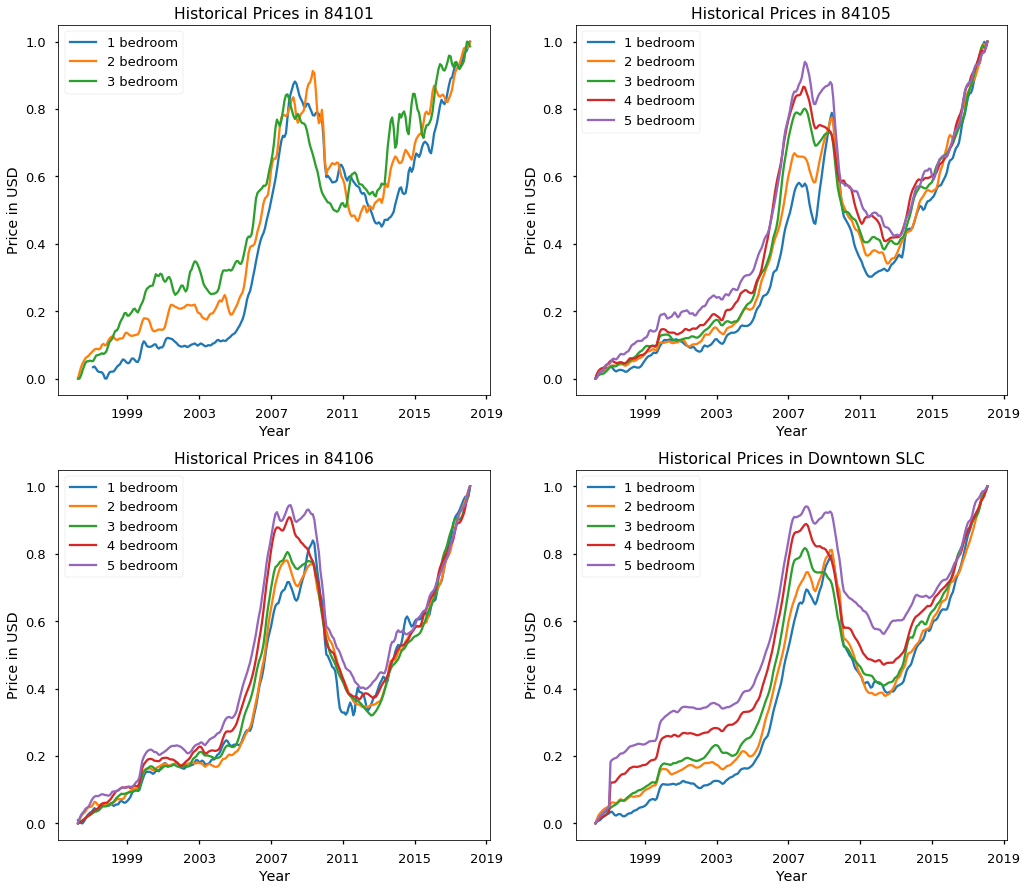

In [66]:
#plot downtown SLC data- NORMALIZED

#make the axes fonts bigger
sns.set_context("talk")
fig = plt.figure(figsize=[17, 15])

# first plot
fig.add_subplot(221)   #top left
plt.plot(one_bed_84101['year_month'],one_bed_84101_norm, label='1 bedroom')
plt.plot(two_bed_84101['year_month'],two_bed_84101_norm, label='2 bedroom')
plt.plot(three_bed_84101['year_month'],three_bed_84101_norm, label='3 bedroom')
plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices in 84101')

# second plot
fig.add_subplot(222)   #top right
plt.plot(one_bed_84105['year_month'],one_bed_84105_norm, label='1 bedroom')
plt.plot(two_bed_84105['year_month'],two_bed_84105_norm, label='2 bedroom')
plt.plot(three_bed_84105['year_month'],three_bed_84105_norm, label='3 bedroom')
plt.plot(four_bed_84105['year_month'],four_bed_84105_norm, label='4 bedroom')
plt.plot(five_bed_84105['year_month'],five_bed_84105_norm, label='5 bedroom')
plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices in 84105')


# third plot
fig.add_subplot(223)   #bottom right
plt.plot(one_bed_84106['year_month'],one_bed_84106_norm, label='1 bedroom')
plt.plot(two_bed_84106['year_month'],two_bed_84106_norm, label='2 bedroom')
plt.plot(three_bed_84106['year_month'],three_bed_84106_norm, label='3 bedroom')
plt.plot(four_bed_84106['year_month'],four_bed_84106_norm, label='4 bedroom')
plt.plot(five_bed_84106['year_month'],five_bed_84106_norm, label='5 bedroom')
plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices in 84106')

# fourth plot
fig.add_subplot(224)   #bottom right
plt.plot(one_bed_downtown.index,one_bed_downtown_norm, label='1 bedroom')
plt.plot(two_bed_downtown.index,two_bed_downtown_norm, label='2 bedroom')
plt.plot(three_bed_downtown.index,three_bed_downtown_norm, label='3 bedroom')
plt.plot(four_bed_downtown.index,four_bed_downtown_norm, label='4 bedroom')
plt.plot(five_bed_downtown.index,five_bed_downtown_norm, label='5 bedroom')
plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices in Downtown SLC')

plt.show()

It looks like small homes in the downtown area don't appreciate faster than other sized homes. Now let's compare data across house size in the east and west suburbs of Salt Lake City.

In [67]:
# scaling median of all east side data
one_bed_millcreek_holladay = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Millcreek_Holladay')
                               &(listings_historical_slc_long['beds'] == 1)].dropna(axis=0, how='any')
two_bed_millcreek_holladay = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Millcreek_Holladay')
                               &(listings_historical_slc_long['beds'] == 2)].dropna(axis=0, how='any')
three_bed_millcreek_holladay = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Millcreek_Holladay')
                               &(listings_historical_slc_long['beds'] == 3)].dropna(axis=0, how='any')
four_bed_millcreek_holladay = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Millcreek_Holladay')
                               &(listings_historical_slc_long['beds'] == 4)].dropna(axis=0, how='any')
five_bed_millcreek_holladay = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Millcreek_Holladay')
                               &(listings_historical_slc_long['beds'] == 5)].dropna(axis=0, how='any')

one_bed_millcreek_holladay = one_bed_millcreek_holladay.groupby('year_month')['price'].mean()
one_bed_millcreek_holladay_norm = pd.DataFrame(min_max_scaler.fit_transform(one_bed_millcreek_holladay))

two_bed_millcreek_holladay = two_bed_millcreek_holladay.groupby('year_month')['price'].mean()
two_bed_millcreek_holladay_norm = pd.DataFrame(min_max_scaler.fit_transform(two_bed_millcreek_holladay))

three_bed_millcreek_holladay = three_bed_millcreek_holladay.groupby('year_month')['price'].mean()
three_bed_millcreek_holladay_norm = pd.DataFrame(min_max_scaler.fit_transform(three_bed_millcreek_holladay))

four_bed_millcreek_holladay = four_bed_millcreek_holladay.groupby('year_month')['price'].mean()
four_bed_millcreek_holladay_norm = pd.DataFrame(min_max_scaler.fit_transform(four_bed_millcreek_holladay))

five_bed_millcreek_holladay = five_bed_millcreek_holladay.groupby('year_month')['price'].mean()
five_bed_millcreek_holladay_norm = pd.DataFrame(min_max_scaler.fit_transform(five_bed_millcreek_holladay))

In [68]:
# scaling median of all west side data
one_bed_west_valley = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'West Valley')
                               &(listings_historical_slc_long['beds'] == 1)].dropna(axis=0, how='any')
two_bed_west_valley = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'West Valley')
                               &(listings_historical_slc_long['beds'] == 2)].dropna(axis=0, how='any')
three_bed_west_valley = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'West Valley')
                               &(listings_historical_slc_long['beds'] == 3)].dropna(axis=0, how='any')
four_bed_west_valley = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'West Valley')
                               &(listings_historical_slc_long['beds'] == 4)].dropna(axis=0, how='any')
five_bed_west_valley = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'West Valley')
                               &(listings_historical_slc_long['beds'] == 5)].dropna(axis=0, how='any')

one_bed_west_valley = one_bed_west_valley.groupby('year_month')['price'].mean()
one_bed_west_valley_norm = pd.DataFrame(min_max_scaler.fit_transform(one_bed_west_valley))

two_bed_west_valley = two_bed_west_valley.groupby('year_month')['price'].mean()
two_bed_west_valley_norm = pd.DataFrame(min_max_scaler.fit_transform(two_bed_west_valley))

three_bed_west_valley = three_bed_west_valley.groupby('year_month')['price'].mean()
three_bed_west_valley_norm = pd.DataFrame(min_max_scaler.fit_transform(three_bed_west_valley))

four_bed_west_valley = four_bed_west_valley.groupby('year_month')['price'].mean()
four_bed_west_valley_norm = pd.DataFrame(min_max_scaler.fit_transform(four_bed_west_valley))

five_bed_west_valley = five_bed_west_valley.groupby('year_month')['price'].mean()
five_bed_west_valley_norm = pd.DataFrame(min_max_scaler.fit_transform(five_bed_west_valley))

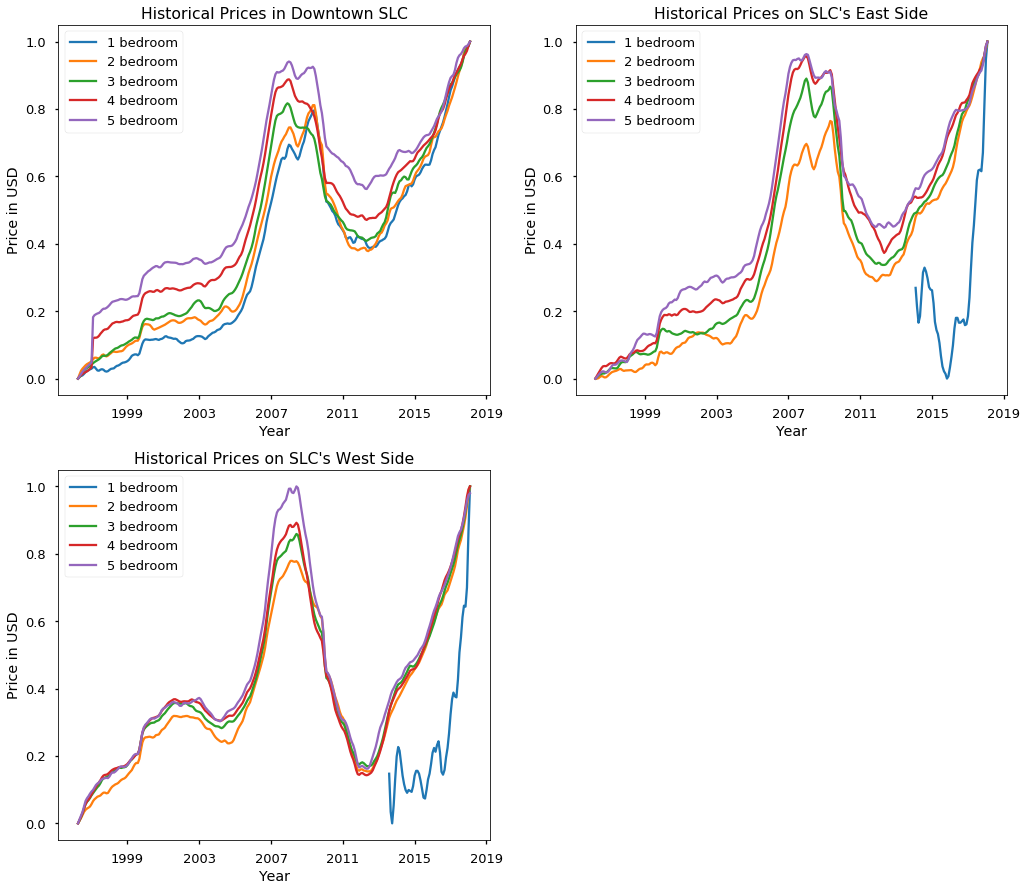

In [69]:
#plot downtown SLC data- NORMALIZED

#make the axes fonts bigger
sns.set_context("talk")
fig = plt.figure(figsize=[17, 15])

# first plot
fig.add_subplot(221)   #top left
plt.plot(one_bed_downtown.index,one_bed_downtown_norm, label='1 bedroom')
plt.plot(two_bed_downtown.index,two_bed_downtown_norm, label='2 bedroom')
plt.plot(three_bed_downtown.index,three_bed_downtown_norm, label='3 bedroom')
plt.plot(four_bed_downtown.index,four_bed_downtown_norm, label='4 bedroom')
plt.plot(five_bed_downtown.index,five_bed_downtown_norm, label='5 bedroom')
plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices in Downtown SLC')

# second plot
fig.add_subplot(222)   #top right
plt.plot(one_bed_millcreek_holladay.index,one_bed_millcreek_holladay_norm, label='1 bedroom')
plt.plot(two_bed_millcreek_holladay.index,two_bed_millcreek_holladay_norm, label='2 bedroom')
plt.plot(three_bed_millcreek_holladay.index,three_bed_millcreek_holladay_norm, label='3 bedroom')
plt.plot(four_bed_millcreek_holladay.index,four_bed_millcreek_holladay_norm, label='4 bedroom')
plt.plot(five_bed_millcreek_holladay.index,five_bed_millcreek_holladay_norm, label='5 bedroom')
plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices on SLC\'s East Side')

# third plot
fig.add_subplot(223)   #bottom right
plt.plot(one_bed_west_valley.index,one_bed_west_valley_norm, label='1 bedroom')
plt.plot(two_bed_west_valley.index,two_bed_west_valley_norm, label='2 bedroom')
plt.plot(three_bed_west_valley.index,three_bed_west_valley_norm, label='3 bedroom')
plt.plot(four_bed_west_valley.index,four_bed_west_valley_norm, label='4 bedroom')
plt.plot(five_bed_west_valley.index,five_bed_west_valley_norm, label='5 bedroom')
plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices on SLC\'s West Side')

plt.show()

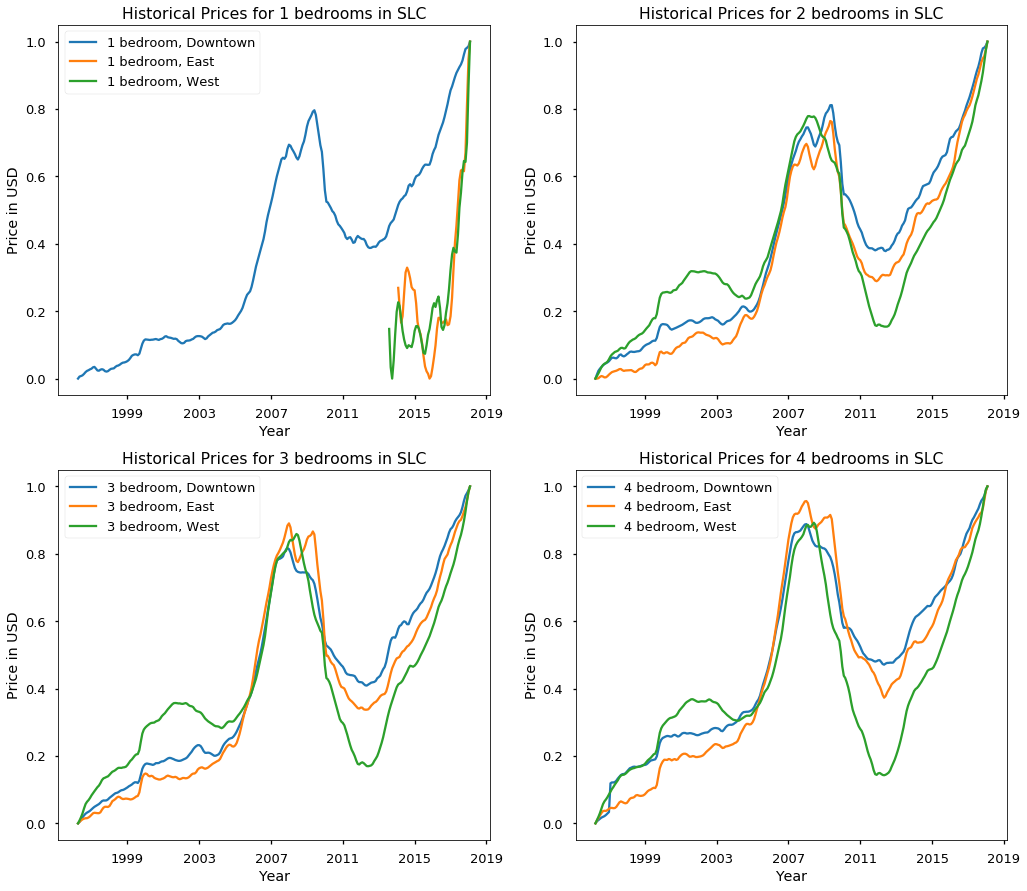

In [70]:
#plot downtown SLC data- NORMALIZED

#make the axes fonts bigger
sns.set_context("talk")
fig = plt.figure(figsize=[17, 15])

# first plot
fig.add_subplot(221)   #top left
plt.plot(one_bed_downtown.index,one_bed_downtown_norm, label='1 bedroom, Downtown')
plt.plot(one_bed_millcreek_holladay.index,one_bed_millcreek_holladay_norm, label='1 bedroom, East')
plt.plot(one_bed_west_valley.index,one_bed_west_valley_norm, label='1 bedroom, West')

plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices for 1 bedrooms in SLC')

# second plot
fig.add_subplot(222)   #top right
plt.plot(two_bed_downtown.index,two_bed_downtown_norm, label='2 bedroom, Downtown')
plt.plot(two_bed_millcreek_holladay.index,two_bed_millcreek_holladay_norm, label='2 bedroom, East')
plt.plot(two_bed_west_valley.index,two_bed_west_valley_norm, label='2 bedroom, West')

plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices for 2 bedrooms in SLC')

# third plot
fig.add_subplot(223)   #bottom right
plt.plot(three_bed_downtown.index,three_bed_downtown_norm, label='3 bedroom, Downtown')
plt.plot(three_bed_millcreek_holladay.index,three_bed_millcreek_holladay_norm, label='3 bedroom, East')
plt.plot(three_bed_west_valley.index,three_bed_west_valley_norm, label='3 bedroom, West')

plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices for 3 bedrooms in SLC')

# third plot
fig.add_subplot(224)   #bottom right
plt.plot(four_bed_downtown.index, four_bed_downtown_norm, label='4 bedroom, Downtown')
plt.plot(four_bed_millcreek_holladay.index, four_bed_millcreek_holladay_norm, label='4 bedroom, East')
plt.plot(four_bed_west_valley.index, four_bed_west_valley_norm, label='4 bedroom, West')

plt.legend()
plt.ylabel('Price in USD')
plt.xlabel('Year')
plt.title('Historical Prices for 4 bedrooms in SLC')


plt.show()

### Plotting un-normalized data by region

In [71]:
one_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 1)].dropna(axis=0, how='any')
two_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 2)].dropna(axis=0, how='any')
three_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 3)].dropna(axis=0, how='any')
four_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 4)].dropna(axis=0, how='any')
five_bed_downtown = listings_historical_slc_long[(listings_historical_slc_long['neighborhood'] == 'Downtown SLC')
                               &(listings_historical_slc_long['beds'] == 5)].dropna(axis=0, how='any')

one_bed_downtown = one_bed_downtown.groupby('year_month')['price'].mean()

two_bed_downtown = two_bed_downtown.groupby('year_month')['price'].mean()

three_bed_downtown = three_bed_downtown.groupby('year_month')['price'].mean()

four_bed_downtown = four_bed_downtown.groupby('year_month')['price'].mean()

five_bed_downtown = five_bed_downtown.groupby('year_month')['price'].mean()


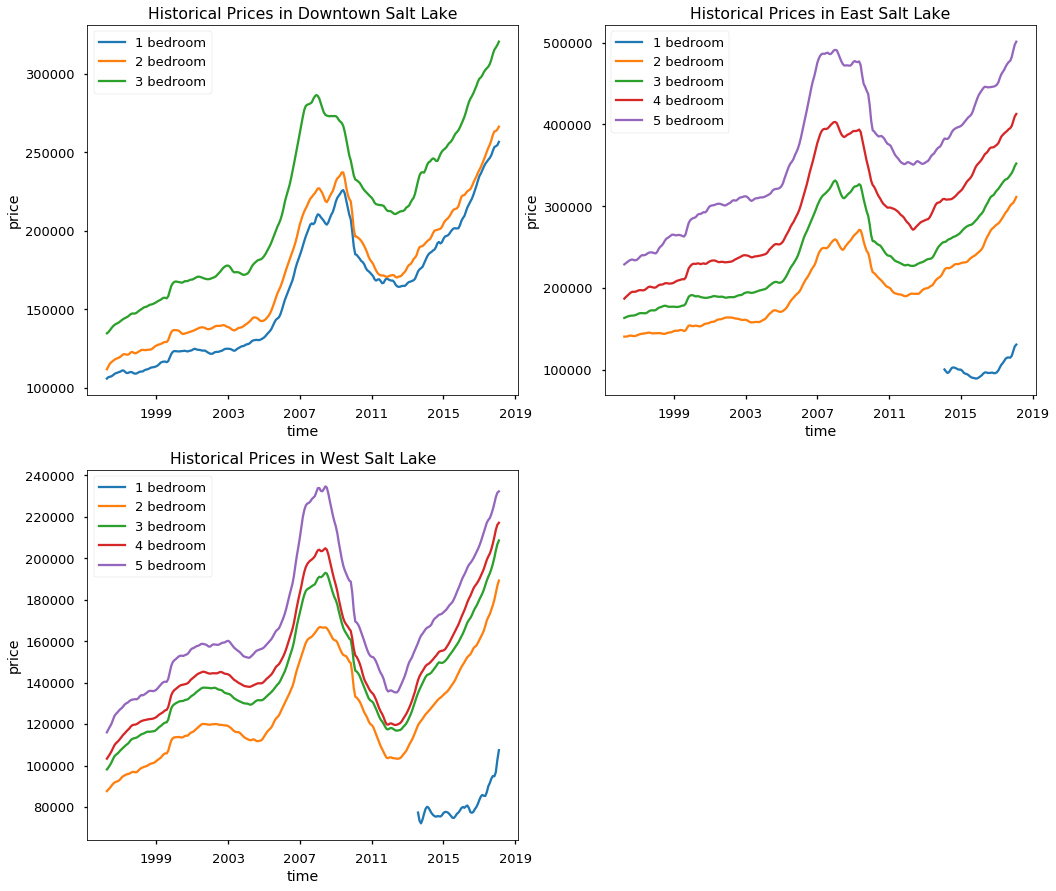

In [72]:
#plot downtown SLC data - DATA NOT NORMALIZED

#make the axes fonts bigger
sns.set_context("talk")
fig = plt.figure(figsize=[17, 15])

# first plot
fig.add_subplot(221)   #top left
plt.plot(one_bed_downtown.index,one_bed_downtown.values, label='1 bedroom')
plt.plot(two_bed_downtown.index,two_bed_downtown.values, label='2 bedroom')
plt.plot(three_bed_downtown.index,three_bed_downtown.values, label='3 bedroom')
#plt.plot(x_84101_4br,y_84101_4br, label='4 bedroom')
#plt.plot(x_84101_5br,y_84101_5br, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices in Downtown Salt Lake')

# second plot
fig.add_subplot(222)   #top left
plt.plot(one_bed_millcreek_holladay.index,one_bed_millcreek_holladay.values, label='1 bedroom')
plt.plot(two_bed_millcreek_holladay.index,two_bed_millcreek_holladay.values, label='2 bedroom')
plt.plot(three_bed_millcreek_holladay.index,three_bed_millcreek_holladay.values, label='3 bedroom')
plt.plot(four_bed_millcreek_holladay.index,four_bed_millcreek_holladay.values, label='4 bedroom')
plt.plot(five_bed_millcreek_holladay.index,five_bed_millcreek_holladay.values, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices in East Salt Lake')

# third plot
fig.add_subplot(223)   #top left
plt.plot(one_bed_west_valley.index,one_bed_west_valley.values, label='1 bedroom')
plt.plot(two_bed_west_valley.index,two_bed_west_valley.values, label='2 bedroom')
plt.plot(three_bed_west_valley.index,three_bed_west_valley.values, label='3 bedroom')
plt.plot(four_bed_west_valley.index,four_bed_west_valley.values, label='4 bedroom')
plt.plot(five_bed_west_valley.index,five_bed_west_valley.values, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices in West Salt Lake')

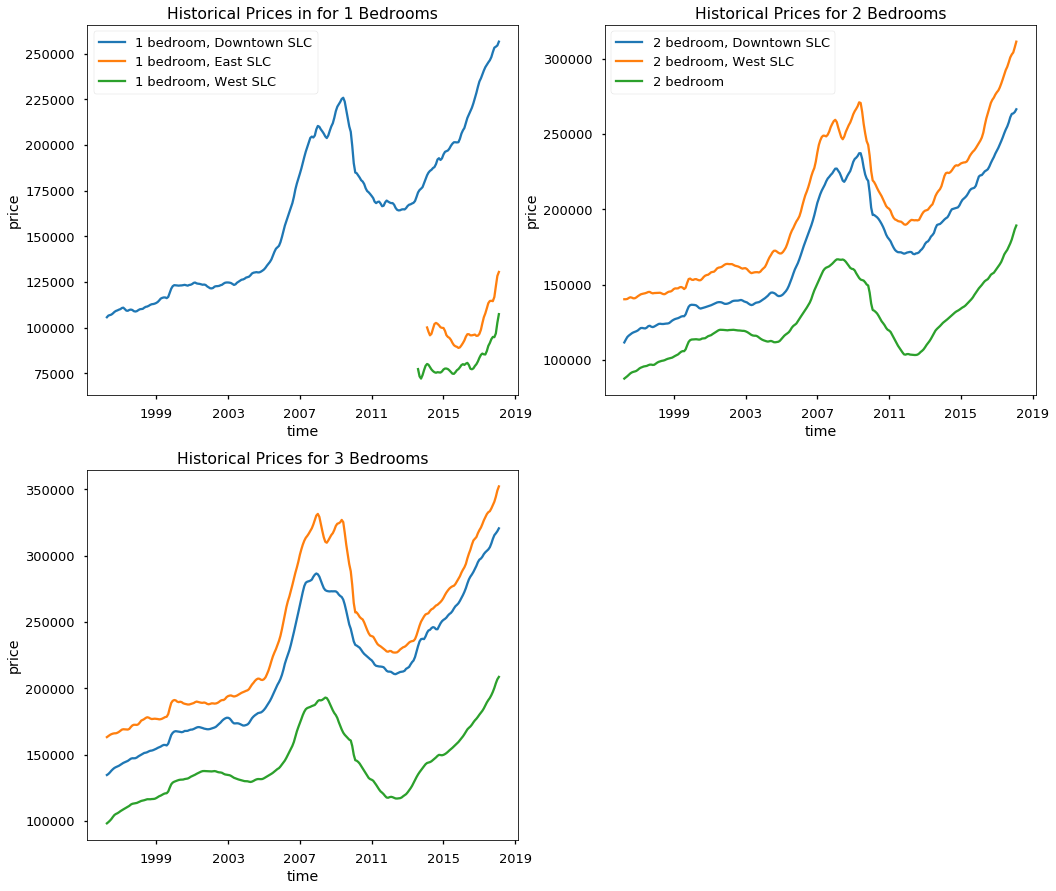

In [73]:
#plot downtown SLC data - DATA NOT NORMALIZED

#make the axes fonts bigger
sns.set_context("talk")
fig = plt.figure(figsize=[17, 15])

# first plot
fig.add_subplot(221)   #top left
plt.plot(one_bed_downtown.index,one_bed_downtown.values, label='1 bedroom, Downtown SLC')
plt.plot(one_bed_millcreek_holladay.index,one_bed_millcreek_holladay.values, label='1 bedroom, East SLC')
plt.plot(one_bed_west_valley.index,one_bed_west_valley.values, label='1 bedroom, West SLC')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices in for 1 Bedrooms')

# second plot
fig.add_subplot(222)   #top left
plt.plot(two_bed_downtown.index,two_bed_downtown.values, label='2 bedroom, Downtown SLC')
plt.plot(two_bed_millcreek_holladay.index,two_bed_millcreek_holladay.values, label='2 bedroom, West SLC')
plt.plot(two_bed_west_valley.index,two_bed_west_valley.values, label='2 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices for 2 Bedrooms')

# third plot
fig.add_subplot(223)   #top left
plt.plot(three_bed_downtown.index,three_bed_downtown.values, label='3 bedroom, Downtown SLC')
plt.plot(three_bed_millcreek_holladay.index,three_bed_millcreek_holladay.values, label='3 bedroom, East SLC')
plt.plot(three_bed_west_valley.index,three_bed_west_valley.values, label='3 bedroom')

plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices for 3 Bedrooms')

### Plotting un-normalized data by zip code

In [74]:
#creating variables for plotting
x_84101_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 1)]['year_month']
y_84101_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 1)]['price']

x_84101_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 2)]['year_month']
y_84101_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 2)]['price']

x_84101_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 3)]['year_month']
y_84101_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 3)]['price']

x_84101_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 4)]['year_month']
y_84101_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 4)]['price']
                               
x_84101_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 5)]['year_month']
y_84101_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84101)
                               &(listings_historical_slc_long['beds'] == 5)]['price']

In [75]:
#creating variables for plotting 84105

x_84105_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 1)]['year_month']
y_84105_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 1)]['price']

x_84105_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 2)]['year_month']
y_84105_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 2)]['price']

x_84105_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 3)]['year_month']
y_84105_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 3)]['price']

x_84105_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 4)]['year_month']
y_84105_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 4)]['price']
                               
x_84105_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 5)]['year_month']
y_84105_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84105)
                               &(listings_historical_slc_long['beds'] == 5)]['price']

In [76]:
#creating variables for plotting 84106

x_84106_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 1)]['year_month']
y_84106_1br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 1)]['price']

x_84106_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 2)]['year_month']
y_84106_2br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 2)]['price']

x_84106_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 3)]['year_month']
y_84106_3br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 3)]['price']

x_84106_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 4)]['year_month']
y_84106_4br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 4)]['price']
                               
x_84106_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)
                               &(listings_historical_slc_long['beds'] == 5)]['year_month']
y_84106_5br=listings_historical_slc_long[(listings_historical_slc_long['postal_code'] == 84106)

                                         &(listings_historical_slc_long['beds'] == 5)]['price']

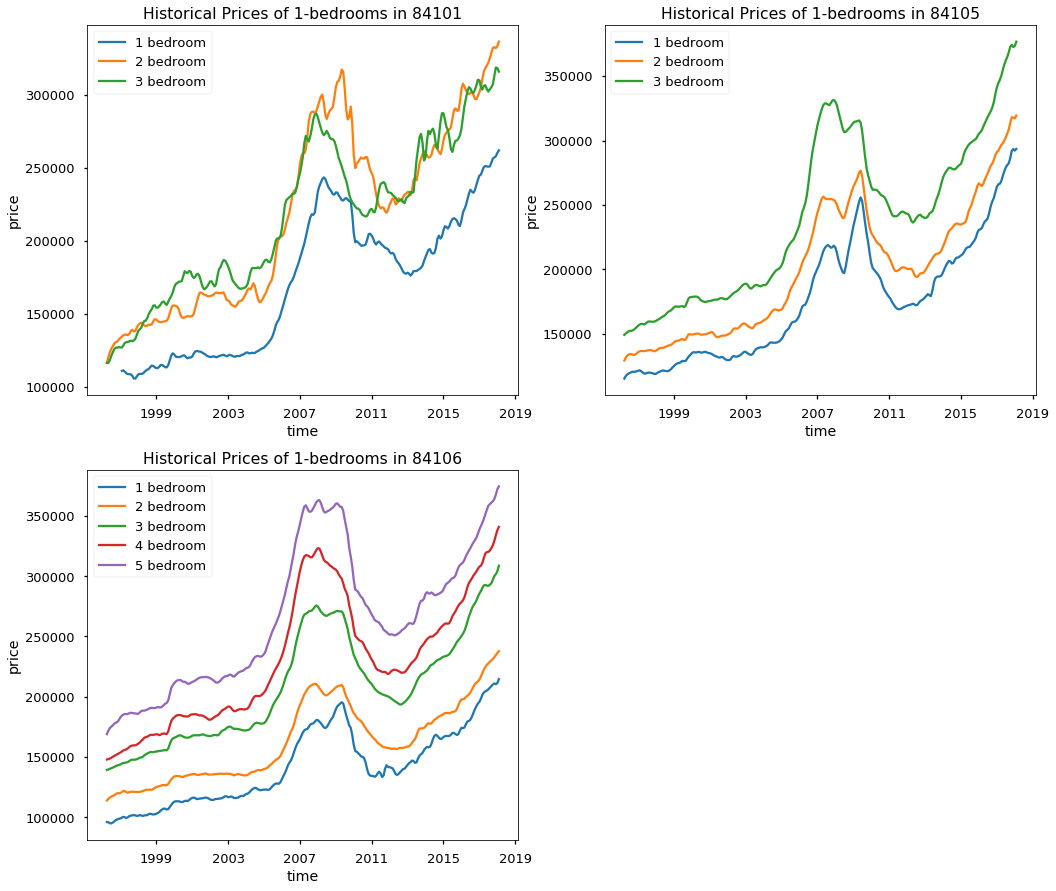

In [77]:
#plot downtown SLC data - DATA NOT NORMALIZED

#make the axes fonts bigger
sns.set_context("talk")
fig = plt.figure(figsize=[17, 15])

# first plot
fig.add_subplot(221)   #top left
plt.plot(x_84101_1br,y_84101_1br, label='1 bedroom')
plt.plot(x_84101_2br,y_84101_2br, label='2 bedroom')
plt.plot(x_84101_3br,y_84101_3br, label='3 bedroom')
#plt.plot(x_84101_4br,y_84101_4br, label='4 bedroom')
#plt.plot(x_84101_5br,y_84101_5br, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices of 1-bedrooms in 84101')

# second plot
fig.add_subplot(222)   #top right
plt.plot(x_84105_1br,y_84105_1br, label='1 bedroom')
plt.plot(x_84105_2br,y_84105_2br, label='2 bedroom')
plt.plot(x_84105_3br,y_84105_3br, label='3 bedroom')
#plt.plot(x_84105_4br,y_84105_4br, label='4 bedroom')
#plt.plot(x_84105_5br,y_84105_5br, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices of 1-bedrooms in 84105')


# third plot
fig.add_subplot(223)   #bottom right
plt.plot(x_84106_1br,y_84106_1br, label='1 bedroom')
plt.plot(x_84106_2br,y_84106_2br, label='2 bedroom')
plt.plot(x_84106_3br,y_84106_3br, label='3 bedroom')
plt.plot(x_84106_4br,y_84106_4br, label='4 bedroom')
plt.plot(x_84106_5br,y_84106_5br, label='5 bedroom')
plt.legend()
plt.ylabel('price')
plt.xlabel('time')
plt.title('Historical Prices of 1-bedrooms in 84106')

plt.show()